In [1]:
import torch
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import types
import json

with open("/data9/cwl/repo/pnpxai/tutorials/data/ImageNet/imagenet_class_index.json", "r") as f:
    imagenet_class_index = json.load(f)

# Forward 함수 수정
def modified_forward(self, x):
    attn_output, attn_output_weights = self.self_attention(x, x, x, need_weights=True, average_attn_weights=False)
    return attn_output


MODEL_WEIGHT = ViT_B_16_Weights.IMAGENET1K_V1

# ViT 모델 로드
model = vit_b_16(weights=MODEL_WEIGHT)
model.eval()

# Attention map 저장용 리스트
attention_maps = []

# Hook 등록 함수
# def get_attention_maps(module, input, output):
#     # output은 (batch_size, num_heads, seq_len, seq_len) 형태의 텐서
#     print(output[0].shape)
#     print(type(input))
#     print(len(input))
#     print(input[0].shape)
#     print(input[1].shape)
#     print(input[2].shape)
#     print(module.num_heads)
#     raise ValueError
#     attention_maps.append(output[0].detach().cpu())

def get_attention_maps(module, input, output):
    # output은 (batch_size, num_heads, seq_len, seq_len) 형태의 텐서
    attention_maps.append(output[1].detach().cpu())

    return output

# forward 수정 적용
for idx, block in enumerate(model.encoder.layers):
    block.forward = types.MethodType(modified_forward, block)
    block.self_attention.register_forward_hook(get_attention_maps)

# 이미지 전처리 함수
def preprocess_image(image_path, transfrom_func):
    image = Image.open(image_path).convert("RGB")
    image = transfrom_func(image).unsqueeze(0)
    return image

# Attention map 시각화 함수
def plot_attention_map(image_path, layer_idx=0, head_idx=None, average_heads=True):
    # 이미지 로드 및 전처리
    transfrom_func = MODEL_WEIGHT.transforms()
    input_tensor = preprocess_image(image_path, transfrom_func)

    # 모델 실행
    attention_maps.clear()
    with torch.no_grad():
        res = model(input_tensor)
        pred = res.argmax(dim=1).item()
        print(imagenet_class_index[str(pred)])

    # 원본 이미지 로드
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))
    
    if layer_idx is None:
        attn_maps = torch.stack(attention_maps, dim=1)
        num_layers = attn_maps.shape[0]
        batch_size = attn_maps.shape[1]
        seq_len = attn_maps.shape[-1]
        lambda_residual = 0
        
        # Head 평균 -> (num_layers, batch_size, seq_len, seq_len)
        attn_maps = attn_maps.mean(dim=2)
        
        # Identity matrix (Residual 추가)
        rollout = torch.eye(seq_len).expand(batch_size, seq_len, seq_len).to(attn_maps.device)
        
        for i in range(num_layers):
            # Residual Connection 반영
            attn = lambda_residual * torch.eye(seq_len).to(attn_maps.device) + (1 - lambda_residual) * attn_maps[i]
            # 행렬 곱 누적
            rollout = torch.matmul(attn, rollout)

        # Attention map 추출
        attn_map = rollout
    else:
        attn_map = attention_maps[layer_idx]  # (1, num_heads, seq_len, seq_len)
    
    if average_heads:
        # 모든 head의 평균값
        attn_map = attn_map.mean(dim=1)  # (1, seq_len, seq_len)
    elif head_idx is not None:
        # 특정 head 선택
        attn_map = attn_map[:, head_idx]  # (1, seq_len, seq_len)

    attn_map = attn_map.squeeze(0)[0, 1:].detach().numpy()
    patch_size = int(np.sqrt(attn_map.shape[0]))
    attn_map = attn_map.reshape(patch_size, patch_size)

    # Normalize for better visualization
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    # 이미지 시각화
    fig, ax = plt.subplots()
    ax.imshow(image)

    # Attention overlay
    im_attn = ax.imshow(attn_map, cmap='jet', alpha=0.6)


    ax.axis('off')
    if layer_idx is not None:
        plt.title(f'Layer {layer_idx + 1} {"(Average of Heads)" if average_heads else f"(Head {head_idx + 1})"}')
    fig.colorbar(im_attn, ax=ax, orientation='vertical')
    plt.show()


In [2]:
def get_attn_map(image_path, layer_idx, head_idx):
    transfrom_func = MODEL_WEIGHT.transforms()
    input_tensor = preprocess_image(image_path, transfrom_func)

    # 모델 실행
    attention_maps.clear()
    with torch.no_grad():
        res = model(input_tensor)
        pred = res.argmax(dim=1).item()

    # 원본 이미지 로드
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))
    
    return attention_maps, res

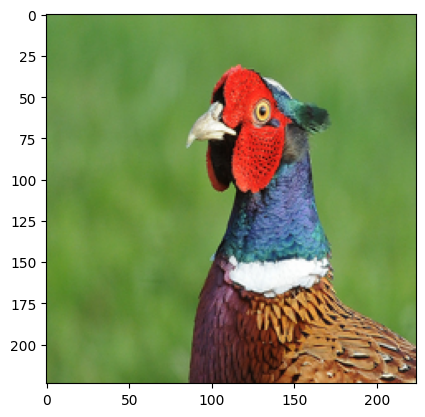

In [6]:
# 이미지 파일 경로
# image_path = "/data9/cwl/repo/pnpxai/tutorials/data/ImageNet/samples/n01440764_tench.JPEG"
# image_path = "/data9/cwl/repo/pnpxai/tutorials/data/ImageNet/samples/n01494475_hammerhead.JPEG"
# image_path = "/data9/cwl/repo/pnpxai/tutorials/data/ImageNet/samples/n01496331_electric_ray.JPEG"
image_path = "/data9/cwl/repo/pnpxai/tutorials/data/ImageNet/samples/n01514668_cock.JPEG"

image = Image.open(image_path).convert("RGB")
image = image.resize((224, 224))
plt.imshow(image)


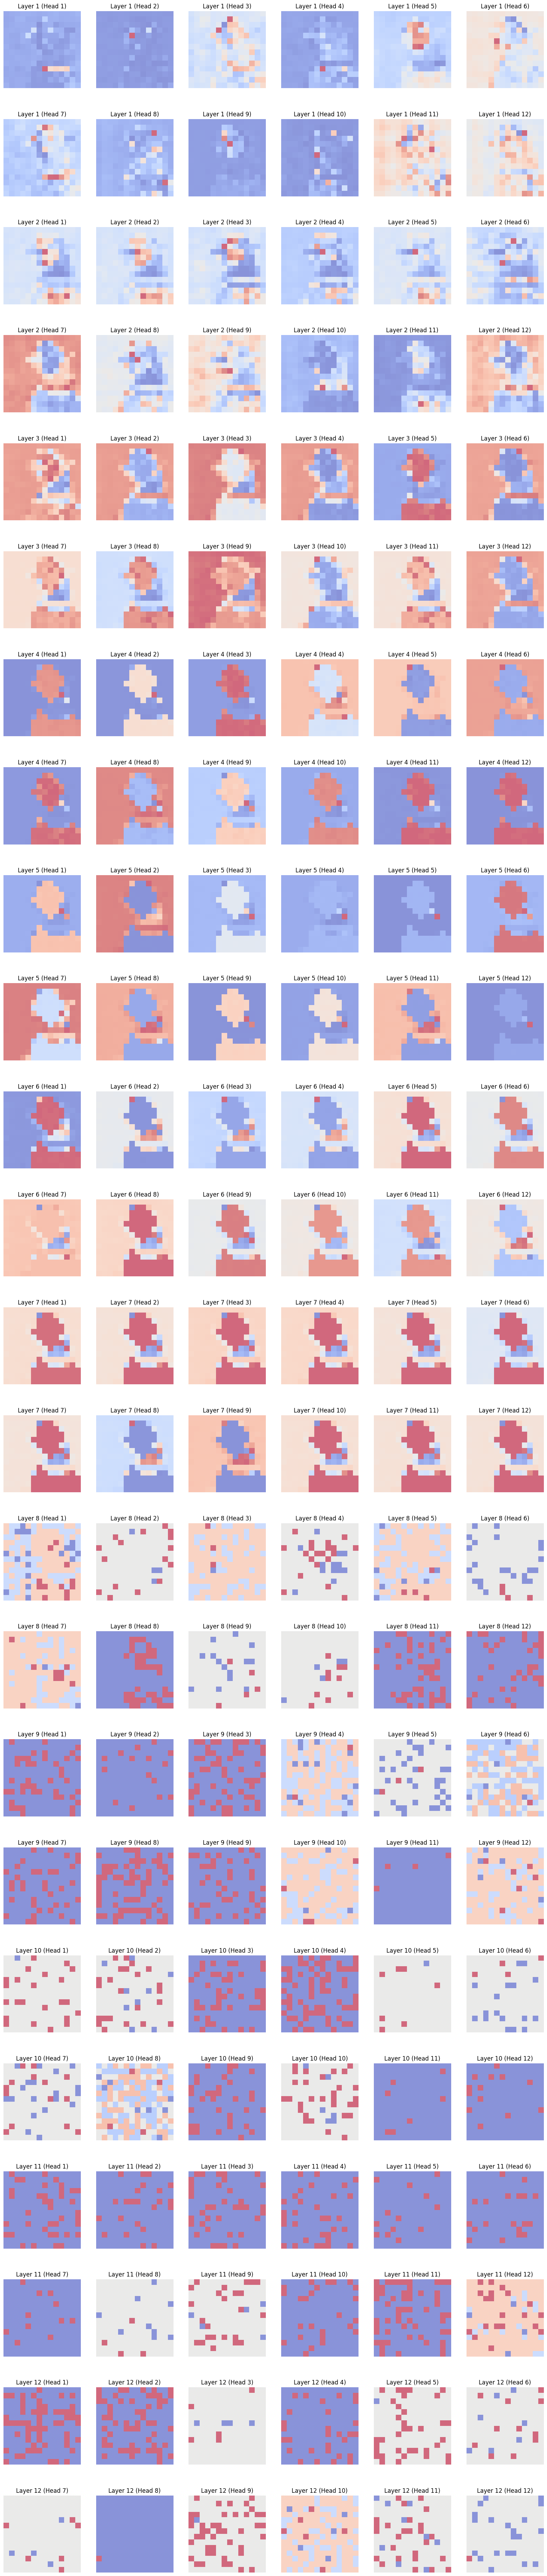

In [4]:
h = 6
# num_layers = 2
# num_heads = 6
num_layers = len(model.encoder.layers)
num_heads = model.encoder.layers[0].num_heads
v = num_layers * num_heads // h

fig, axes = plt.subplots(v, h, figsize=(20, 4 * v))
flatten_axes = axes.flatten()

idx = 0
for layer_idx in range(num_layers):
    for head_idx in range(num_heads):
        attn_map, res = get_attn_map(image_path, layer_idx, head_idx)
        attn_map = attention_maps[layer_idx]  # (1, num_heads, seq_len, seq_len)
        attn_map = attn_map[:, head_idx]  # (1, seq_len, seq_len)
        attn_map = attn_map.squeeze(0)[0, 1:].detach().numpy()
        patch_size = int(np.sqrt(attn_map.shape[0]))
        attn_map = attn_map.reshape(patch_size, patch_size)

        # Normalize for better visualization
        attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())
        im_attn = flatten_axes[idx].imshow(attn_map, cmap='coolwarm', alpha=0.6)
        flatten_axes[idx].axis('off')
        flatten_axes[idx].set_title(f'Layer {layer_idx + 1} (Head {head_idx + 1})')

        idx += 1
# fig.colorbar(im_attn, ax=flatten_axes, orientation='vertical')
plt.show()


In [5]:
STOP

NameError: name 'STOP' is not defined